# TabTransformer Testing

In this notebook, I will use the TabTransformer model with more than 500 atm data.

In [1]:
import matplotlib.pyplot as plt

sys.path.append(r'../atm_demand')
from feature_generation import *
from models import *
from forecasting import nmae_error

import pandas as pd
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("../atm_demand/DATA_sample_atm.csv")
all_atms_feature_set = get_all_atms_feature_set(df, first_n = 500)

all_atms_feature_set = add_cluster_features(all_atms_feature_set,
    [('Day_of_the_Week_Index', 10),
    ('Special_Lunar_Dates_Index', 9),
    ('Month_of_the_Year_Index', 10)],
    'CashIn', KMeans)
    
all_atms_feature_set.sort_index(inplace = True)

In [3]:
categorical_features = [cat for cat in all_atms_feature_set.select_dtypes(include=['int8', 'int64'])
    if cat not in ['AtmId', 'Day_Index_0', 'Day_Index_1', 'Day_Index_2',
    'Day_Index_3', 'Day_Index_4', 'Day_Index_5', 'Day_Index_6', 'Is_Weekend',
    'curr_month_1_delta', 'curr_month_15_delta', 'next_month_1_delta',
    'is_ramazan', 'ramazan_in_7_days', 'is_kurban', 'kurban_in_7_days',
    'is_cocuk_bayrami', 'is_isci_bayrami', 'is_spor_bayrami',
    'is_zafer_bayrami', 'is_cumhuriyet_bayrami']]
continuous_features = [cont for cont in all_atms_feature_set.select_dtypes(include='float64')
    if cont not in ['CashIn', 'CashOut']]

groups = [continuous_features]
groups.extend(categorical_features)

TARGET = 'CashIn'
X_train, X_test, y_train, y_test = train_test_split(all_atms_feature_set[all_atms_feature_set.columns[2:]], all_atms_feature_set[TARGET])

train_inputs = get_input_sets(X_train, groups)
test_inputs  = get_input_sets(X_test, groups)

In [4]:
tabTransforer = TabTransformer(
    categories = [len(all_atms_feature_set[categorical].unique()) for categorical in categorical_features],
    num_continuous = len(continuous_features),
    dim = 16,
    dim_out = 1,
    depth = 6,
    heads = 8,
    attn_dropout = 0.1,
    ff_dropout = 0.1,
    mlp_hidden = [(128, 'relu'), (64, 'relu'), (16, 'relu')]
)

In [5]:
tabTransforer.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mse')

In [6]:
history = tabTransforer.fit(train_inputs, 
            y_train,
            batch_size=1024,
            epochs=30,
            validation_data=(test_inputs, y_test),
            verbose = 1)

Epoch 1/30
526/526 [==============================] - 332s 603ms/step - loss: 1534249103.0588 - val_loss: 1180657152.0000
Epoch 2/30
526/526 [==============================] - 316s 600ms/step - loss: 1168888910.4516 - val_loss: 1141466368.0000
Epoch 3/30
526/526 [==============================] - 323s 615ms/step - loss: 1135856559.3624 - val_loss: 1127561216.0000
Epoch 4/30
526/526 [==============================] - 343s 653ms/step - loss: 1113505660.3567 - val_loss: 1110916608.0000
Epoch 5/30
526/526 [==============================] - 333s 634ms/step - loss: 1111781500.2353 - val_loss: 1097115008.0000
Epoch 6/30
526/526 [==============================] - 342s 650ms/step - loss: 1089926421.0095 - val_loss: 1097933312.0000
Epoch 7/30
526/526 [==============================] - 340s 647ms/step - loss: 1081784464.1518 - val_loss: 1078997888.0000
Epoch 8/30
526/526 [==============================] - 333s 633ms/step - loss: 1075913470.0569 - val_loss: 1093810432.0000
Epoch 9/30
526/526 [====

In [7]:
def plot_history(history):
    plt.figure(figsize=(10,4))
    for key in history.history:
        plt.plot(history.history[key][:], label = key)
    plt.legend()
    plt.show()

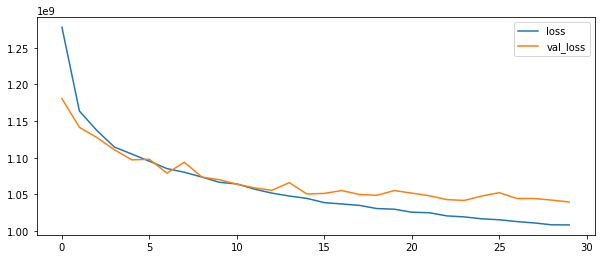

In [8]:
plot_history(history)

In [9]:
"Train score: %.4f, test score: %.4f" % (nmae_error(tabTransforer.predict(train_inputs).reshape(-1), y_train), nmae_error(tabTransforer.predict(test_inputs).reshape(-1), y_test))

'Train score: 0.3944, test score: 0.4019'

In [10]:
# Reference: https://www.tensorflow.org/tutorials/keras/save_and_load
tabTransforer.save_weights('./model/tabTransformer')